In [11]:
import pandas as pd
import numpy as np
from shutil import copyfile

import os
import cv2 as cv
from PIL import Image
import skimage.io as io

import segmentation_models_pytorch as smp
import torch
import torchvision.transforms as transforms
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from ipywidgets import interact, Text, RadioButtons, fixed, FloatSlider
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:

import warnings
warnings.filterwarnings("ignore")

In [3]:
def read_from_tf_records(tf_records_path):
    """
    Reads images, labels from tfrecords files.
    :param tf_records_path: list of tfrecord file names
    :return: lists of
    """
    img_heights, img_widths, dice_scores, imgs, masks, results, img_names, metrics = [], [], [], [], [], [], [], []

    assert os.path.isfile(tf_records_path)
    record_iterator = tf.python_io.tf_record_iterator(tf_records_path)
    for serialized_example in record_iterator:
        
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        
        img_raw = example.features.feature['img_raw'].bytes_list.value
        msk_raw = example.features.feature['mask_raw'].bytes_list.value
        rst_raw = example.features.feature['pred_raw'].bytes_list.value
        
        img_height = example.features.feature['img_height'].int64_list.value
        img_width = example.features.feature['img_width'].int64_list.value
        image_name = example.features.feature['img_name'].bytes_list.value
        
        dice_score = example.features.feature['dice_score'].float_list.value
        metric= example.features.feature['metric'].float_list.value
        
        image = Image.frombytes('RGB', (img_width[0], img_height[0]), img_raw[0])
        mask = Image.frombytes('RGB', (img_width[0], img_height[0]), msk_raw[0])
        result = Image.frombytes('RGB', (img_width[0], img_height[0]), rst_raw[0])
        
        img_heights.append(img_height[0])
        img_widths.append(img_width[0])
        img_names.append(image_name[0])
        
        dice_scores.append(dice_score[0])
        metrics.append(metric[0])
        
        imgs.append(np.array(image))
        masks.append(np.array(mask))
        results.append(np.array(result))


    return img_heights, img_widths, np.array(dice_scores), np.array(imgs), np.array(masks), np.array(results), np.array(img_names), np.array(metrics)

In [4]:
def visualize_tfr(image, mask, result, dices, names, metrics):
    grid_width=2
    grid_height=6

    fig = plt.figure(figsize=(20, 22))
    outer = gridspec.GridSpec(grid_height, grid_width, wspace=0.1, hspace=0.1)

    for i in range(grid_height * grid_width):
        inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        try:
            for j, (im, cls, label) in enumerate(zip([image[i], mask[i], result[i]],
                                                     ['Image', 'Mask', 'Result'],
                                                     [dices[i], names[i], names[i]])):
                ax = plt.Subplot(fig, inner[j])
                ax.set_title(cls)
                if cls == 'Image':
                    ax.imshow(im)

                elif cls == 'Mask':
                    ax.imshow(im, cmap=plt.cm.jet)
                    ax.set_xlabel(str(names[i]) + ' dice: ' + str(round(dices[i], 4)) + ' metric: ' + str(round(metrics[i], 4)))
                else:
                    prediction = np.zeros(im.shape)
                    prediction[im > 128]=1
                    ax.imshow(prediction, cmap=plt.cm.jet)

                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)
        except:
            continue

In [5]:
def visualize_tf_records_inter(tfr, epsilon=0.05, num_samples=18):
    img_heights, img_widths, dice_scores, imgs, masks, results, img_names, metrics = read_from_tf_records(tfr)
    print("Average dice:", round(np.average(dice_scores), 4))
    def on_value_change(dice):
        
        indxs = np.where((dice_scores < dice+epsilon) & (dice_scores > dice-epsilon))[0]

        step = num_samples
        parts = int(np.ceil(len(indxs)/step))
        print("Pages: {0}".format(parts))

        
        def view_image(i):
            start = i*step
            finish = step + i*step
            ind = indxs[start:finish]
            visualize_tfr(imgs[ind], masks[ind], results[ind], dice_scores[ind], img_names[ind], metrics[ind])
        
        interact(view_image, i=(0, parts-1), value=0)

    interact(on_value_change, dice=FloatSlider(min=epsilon, max=1.0-epsilon, step=0.05, continuous_update=False, value=0.5));

In [6]:
visualize_tf_records_inter('''../../test_data/unet50_ws_predictions/prediction_metrics.tfrecords''',
                           epsilon=0.05,
                           num_samples=8)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Average dice: 0.5056


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='dice', max=0.95, min=0.05, …

In [12]:
model = smp.Unet('resnet50', encoder_weights='imagenet')
checkpoint = torch.load('../../models/unet50_best.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

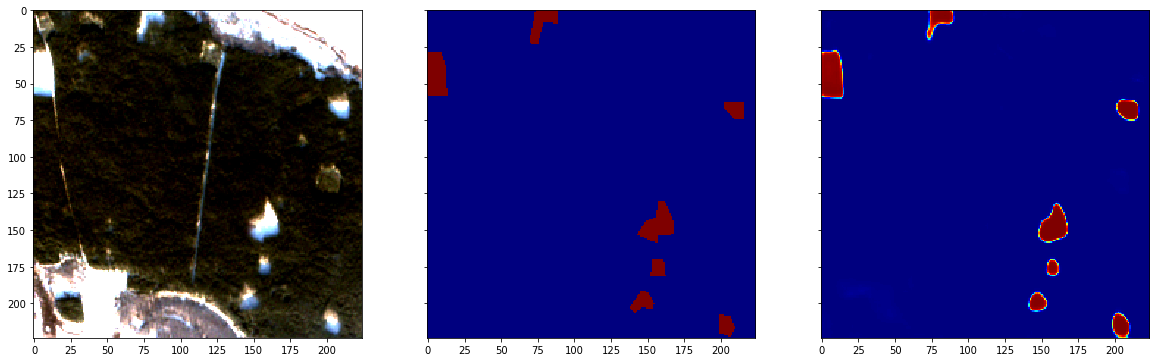

In [138]:
img_path = "../../test_data/preprocessed_winter/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb/images/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb_48_8.tiff"
mask_path = "../../test_data/preprocessed_winter/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb/masks/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb_48_8.png"


img = Image.open(img_path)
mask = Image.open(mask_path)

img_tensor = transforms.ToTensor()(img)

prediction = model.predict(img_tensor.view(1, 3, 224, 224))

result = prediction.view(224, 224).detach().numpy()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20), sharey=True)

ax1.imshow(img)
ax2.imshow(mask, cmap=plt.cm.jet)
ax3.imshow(result, cmap=plt.cm.jet)

In [134]:
img_array = np.array(img).astype('float32') / 255.
predicted_mask = np.stack([result, np.zeros((224, 224)).astype('float32'), np.zeros((224, 224)).astype('float32')], axis=2)
mask_array = np.array(mask).astype('float32') / 255.
gt_mask = np.stack([mask_array, np.zeros((224, 224)).astype('float32'), np.zeros((224, 224)).astype('float32')], axis=2)


In [ ]:
alpha = 0.3
beta = 1 - alpha
gamma = 0.2

predicted_and_image = cv.addWeighted(predicted_mask, alpha, img_array, beta, gamma)
mask_and_image = cv.addWeighted(gt_mask, alpha, img_array, beta, gamma)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


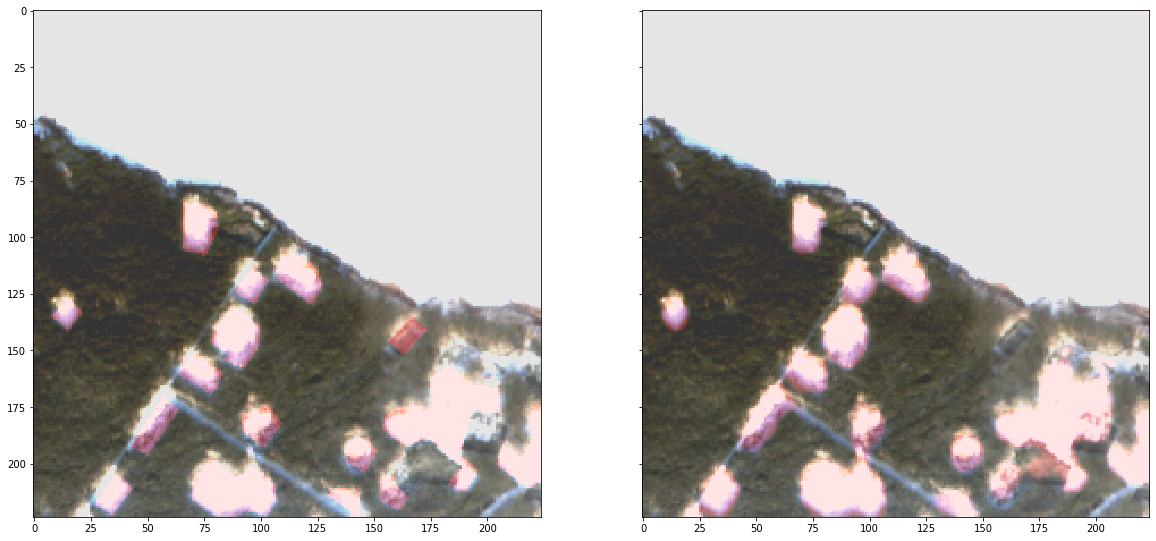

In [135]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), sharey=True)


ax1.imshow(mask_and_image)
ax2.imshow(predicted_and_image)